In [ ]:
!pip install transformers==4.37.2
!pip install accelerate==0.27.2
!pip install torch


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# STEP 3: Load and Combine Datasets
import pandas as pd

# Update paths to match your folder
devign_df = pd.read_csv('/content/drive/MyDrive/devign_project/devign_tokens.csv')
bigvul_df = pd.read_csv('/content/drive/MyDrive/devign_project/bigvul_tokens.csv')
nvd_df = pd.read_csv('/content/drive/MyDrive/devign_project/nvd_tokens.csv')

combined_df = pd.concat([devign_df, bigvul_df, nvd_df], ignore_index=True)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(combined_df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")


Train: 177012 | Val: 19668 | Test: 21854


In [13]:
# STEP 4: Prepare Dataset Class
import torch
from torch.utils.data import Dataset

class VulnDataset(Dataset):
    def __init__(self, df):
        self.input_ids = df['input_ids'].apply(eval).tolist()
        self.attention_mask = df['attention_mask'].apply(eval).tolist()
        self.labels = df['label'].tolist()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor(self.attention_mask[idx], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = VulnDataset(train_df)
val_dataset = VulnDataset(val_df)
test_dataset = VulnDataset(test_df)


In [4]:
# STEP 5: Load Model
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "microsoft/codebert-base",
    num_labels=2
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/498 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# STEP 6: Define TrainingArguments and Trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/vuln_model_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=3,  # Increase to 5+ if needed
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/vuln_logs",
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # Use 'eval_f1' instead of 'f1' if using compute_metrics
    greater_is_better=True, # Add this line if 'f1' is the metric to maximize
    fp16=False, # Disable automatic mixed precision
)

# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    # Ensure labels and predictions are integers
    labels = labels.astype(int)
    predictions = predictions.astype(int)

    # Calculate accuracy separately as it's usually well-defined
    acc = accuracy_score(labels, predictions)

    # Initialize metrics to 0.0
    precision, recall, f1 = 0.0, 0.0, 0.0

    # Calculate precision, recall, and f1, handling potential errors or NaN values
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)
        # Explicitly handle NaN values
        if np.isnan(precision):
            precision = 0.0
        if np.isnan(recall):
            recall = 0.0
        if np.isnan(f1):
            f1 = 0.0
    except Exception as e:
        # Fallback to 0.0 if any unexpected error occurs
        print(f"An unexpected error occurred in precision_recall_fscore_support: {e}")
        precision, recall, f1 = 0.0, 0.0, 0.0

    metrics = {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}
    return metrics

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'clear_device_cache' from 'accelerate.utils.memory' (/usr/local/lib/python3.11/dist-packages/accelerate/utils/memory.py)

In [8]:
import os
os.listdir("/content/drive/MyDrive/vuln_model_output")


['checkpoint-44254', 'checkpoint-66381']

In [9]:
from transformers import RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "/content/drive/MyDrive/vuln_model_output/checkpoint-66381",
    num_labels=2
)


In [10]:
from transformers import Trainer, TrainingArguments

# Re-initialize TrainingArguments with necessary parameters for evaluation
# Only per_device_eval_batch_size is strictly needed for evaluation
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/vuln_model_output", # Output directory is still required
    per_device_eval_batch_size=16,
    # Set remove_unused_columns to False if your dataset has columns not used by the model
    remove_unused_columns=False,
)

trainer = Trainer(
    model=model,
    args=training_args
)

In [14]:
results = trainer.evaluate(test_dataset)
print(results)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shivanisawant7751 (shivanisawant7751-heriot-watt-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.2883537709712982, 'eval_runtime': 160.766, 'eval_samples_per_second': 135.937, 'eval_steps_per_second': 8.497}


In [15]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Get predictions again if needed
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, pred_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='binary')

# Print them
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.9041
Precision: 0.6997
Recall:    0.3056
F1 Score:  0.4254


In [17]:
results_summary = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'Eval Loss': results['eval_loss'] # Get eval_loss from the results of trainer.evaluate
}

import json
with open("/content/drive/MyDrive/model_eval_summary.json", "w") as f:
    json.dump(results_summary, f, indent=4)

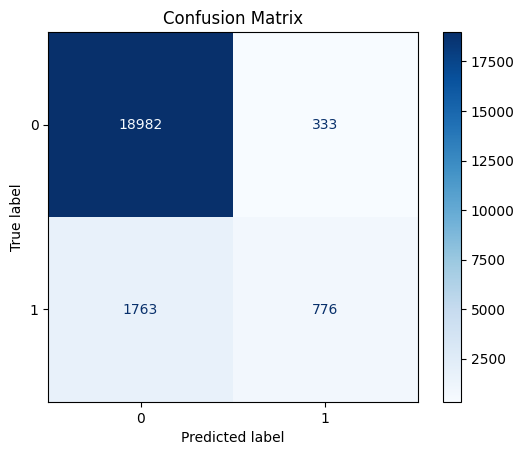

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.savefig("/content/drive/MyDrive/confusion_matrix.png")
plt.show()


In [ ]:
# Manual Evaluation after Training

# Make predictions on the validation dataset
predictions = trainer.predict(val_dataset)

# The predictions object contains logits and labels
eval_results = compute_metrics((predictions.predictions, predictions.label_ids))

print("Manual Evaluation Results:")
print(eval_results)

In [ ]:
!pip uninstall -y transformers accelerate huggingface-hub
!rm -rf /usr/local/lib/python3.11/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.11/dist-packages/accelerate*
!rm -rf /root/.cache/huggingface


Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
Found existing installation: huggingface-hub 0.33.5
Uninstalling huggingface-hub-0.33.5:
  Successfully uninstalled huggingface-hub-0.33.5


In [ ]:
import os
os.kill(os.getpid(), 9)


In [ ]:
!pip install transformers==4.37.2
!pip install accelerate==0.27.2
!pip install torch

  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


In [ ]:
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
print("transformer check.")

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
cannot import name 'clear_device_cache' from 'accelerate.utils.memory' (/usr/local/lib/python3.11/dist-packages/accelerate/utils/memory.py)

In [ ]:
!pip uninstall -y transformers accelerate huggingface-hub
!rm -rf /usr/local/lib/python3.11/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.11/dist-packages/accelerate*
!rm -rf /root/.cache/huggingface
!pip install transformers==4.37.2
!pip install accelerate==0.27.2
!pip install torch

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
Found existing installation: huggingface-hub 0.34.3
Uninstalling huggingface-hub-0.34.3:
  Successfully uninstalled huggingface-hub-0.34.3
  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
  Using cached huggingface_hub-0.34.3-py3-none-any.whl.metadata (14 kB)
Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
Using cached huggingface_hub-0.34.3-py3-none-any.whl (558 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which

  Using cached accelerate-0.27.2-py3-none-any.whl.metadata (18 kB)
Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)


In [6]:
!pip uninstall -y transformers accelerate huggingface-hub
!rm -rf /usr/local/lib/python3.11/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.11/dist-packages/accelerate*
!rm -rf /root/.cache/huggingface

!pip install transformers==4.37.2
!pip install accelerate==0.27.2
!pip install torch

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
Found existing installation: huggingface-hub 0.34.3
Uninstalling huggingface-hub-0.34.3:
  Successfully uninstalled huggingface-hub-0.34.3
  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
  Using cached huggingface_hub-0.34.3-py3-none-any.whl.metadata (14 kB)
Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
Using cached huggingface_hub-0.34.3-py3-none-any.whl (558 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which

  Using cached accelerate-0.27.2-py3-none-any.whl.metadata (18 kB)
Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)


KeyboardInterrupt: 

In [1]:
!pip uninstall -y transformers accelerate huggingface-hub
!rm -rf /usr/local/lib/python3.11/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.11/dist-packages/accelerate*
!rm -rf /root/.cache/huggingface

!pip install transformers==4.37.2
!pip install accelerate==0.27.2
!pip install torch

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
Found existing installation: huggingface-hub 0.34.3
Uninstalling huggingface-hub-0.34.3:
  Successfully uninstalled huggingface-hub-0.34.3
  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
  Using cached huggingface_hub-0.34.3-py3-none-any.whl.metadata (14 kB)
Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
Using cached huggingface_hub-0.34.3-py3-none-any.whl (558 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which

In [3]:
!pip uninstall -y peft

Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0


In [4]:
# STEP 6: Define TrainingArguments and Trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/vuln_model_output",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=3,  # Increase to 5+ if needed
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/vuln_logs",
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # Use 'eval_f1' instead of 'f1' if using compute_metrics
    greater_is_better=True, # Add this line if 'f1' is the metric to maximize
    fp16=False, # Disable automatic mixed precision
)

# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    # Ensure labels and predictions are integers
    labels = labels.astype(int)
    predictions = predictions.astype(int)

    # Calculate accuracy separately as it's usually well-defined
    acc = accuracy_score(labels, predictions)

    # Initialize metrics to 0.0
    precision, recall, f1 = 0.0, 0.0, 0.0

    # Calculate precision, recall, and f1, handling potential errors or NaN values
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)
        # Explicitly handle NaN values
        if np.isnan(precision):
            precision = 0.0
        if np.isnan(recall):
            recall = 0.0
        if np.isnan(f1):
            f1 = 0.0
    except Exception as e:
        # Fallback to 0.0 if any unexpected error occurs
        print(f"An unexpected error occurred in precision_recall_fscore_support: {e}")
        precision, recall, f1 = 0.0, 0.0, 0.0

    metrics = {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}
    return metrics

RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
No module named 'peft'

In [5]:
!pip uninstall -y transformers accelerate huggingface-hub peft
!rm -rf /usr/local/lib/python3.11/dist-packages/transformers*
!rm -rf /usr/local/lib/python3.11/dist-packages/accelerate*
!rm -rf /usr/local/lib/python3.11/dist-packages/peft*
!rm -rf /root/.cache/huggingface

!pip install transformers==4.37.2
!pip install accelerate==0.27.2
!pip install torch
!pip install peft==0.10.0 # Installing a compatible version of peft

Found existing installation: transformers 4.37.2
Uninstalling transformers-4.37.2:
  Successfully uninstalled transformers-4.37.2
Found existing installation: accelerate 0.27.2
Uninstalling accelerate-0.27.2:
  Successfully uninstalled accelerate-0.27.2
Found existing installation: huggingface-hub 0.34.3
Uninstalling huggingface-hub-0.34.3:
  Successfully uninstalled huggingface-hub-0.34.3
  Using cached transformers-4.37.2-py3-none-any.whl.metadata (129 kB)
  Using cached huggingface_hub-0.34.3-py3-none-any.whl.metadata (14 kB)
Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
Using cached huggingface_hub-0.34.3-py3-none-any.whl (558 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.2 which is incompatible.


  Using cached accelerate-0.27.2-py3-none-any.whl.metadata (18 kB)
Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 5.4 MB/s eta 0:00:00


In [7]:
# STEP 6: Define TrainingArguments and Trainer
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/vuln_model_output",
    evaluation_strategy="epoch", # Changed from eval_strategy
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=3,  # Increase to 5+ if needed
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/vuln_logs",
    logging_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    # Use 'eval_f1' instead of 'f1' if using compute_metrics
    greater_is_better=True, # Add this line if 'f1' is the metric to maximize
    fp16=False, # Disable automatic mixed precision
)

# Define metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    # Ensure labels and predictions are integers
    labels = labels.astype(int)
    predictions = predictions.astype(int)

    # Calculate accuracy separately as it's usually well-defined
    acc = accuracy_score(labels, predictions)

    # Initialize metrics to 0.0
    precision, recall, f1 = 0.0, 0.0, 0.0

    # Calculate precision, recall, and f1, handling potential errors or NaN values
    try:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary', zero_division=0)
        # Explicitly handle NaN values
        if np.isnan(precision):
            precision = 0.0
        if np.isnan(recall):
            recall = 0.0
        if np.isnan(f1):
            f1 = 0.0
    except Exception as e:
        # Fallback to 0.0 if any unexpected error occurs
        print(f"An unexpected error occurred in precision_recall_fscore_support: {e}")
        precision, recall, f1 = 0.0, 0.0, 0.0

    metrics = {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}
    return metrics